In [1]:
import tensorflow as tf 
from tensorflow.keras.optimizers import RMSprop,SGD
import keras_preprocessing 
from keras_preprocessing import image
from keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from keras.preprocessing.image import ImageDataGenerator 
from keras.applications import vgg16
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import preprocess_input as vgg_pi
from keras.applications.resnet50 import preprocess_input as resnet_pi
import matplotlib.pyplot as plt
import matplotlib.image as mping 
import numpy as np
import os

from keras import regularizers
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from PIL import Image

Using TensorFlow backend.


In [2]:
train_gen = ImageDataGenerator(rescale= 1./255,
                              rotation_range=30, 
                              width_shift_range=0.15,
                               height_shift_range=0.15,
                               shear_range=0.15, 
                               zoom_range=0.2,
                               horizontal_flip=True, 
                               fill_mode="nearest")
val_gen = ImageDataGenerator(rescale= 1./255)
test_gen = ImageDataGenerator(rescale= 1./255)

In [3]:
train_dir =  r"C:\Users\NOELII\Desktop\hb\RiceDiseaseDataset\train"
train_data =train_gen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    classes=['BrownSpot', 'Healthy', 'Hispa', 'LeafBlast'],
    batch_size=32,
    class_mode='categorical')

Found 1895 images belonging to 4 classes.


In [4]:
test_dir =  r"C:\Users\NOELII\Desktop\hb\RiceDiseaseDataset\test"
test_data =test_gen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    classes=['BrownSpot', 'Healthy', 'Hispa', 'LeafBlast'],
    batch_size=10,
    class_mode='categorical')

Found 77 images belonging to 4 classes.


In [5]:
val_dir = r"C:\Users\NOELII\Desktop\hb\RiceDiseaseDataset\validation"
val_data = val_gen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    classes=['BrownSpot', 'Healthy', 'Hispa', 'LeafBlast'],
    batch_size=10,
    class_mode='categorical')

Found 277 images belonging to 4 classes.


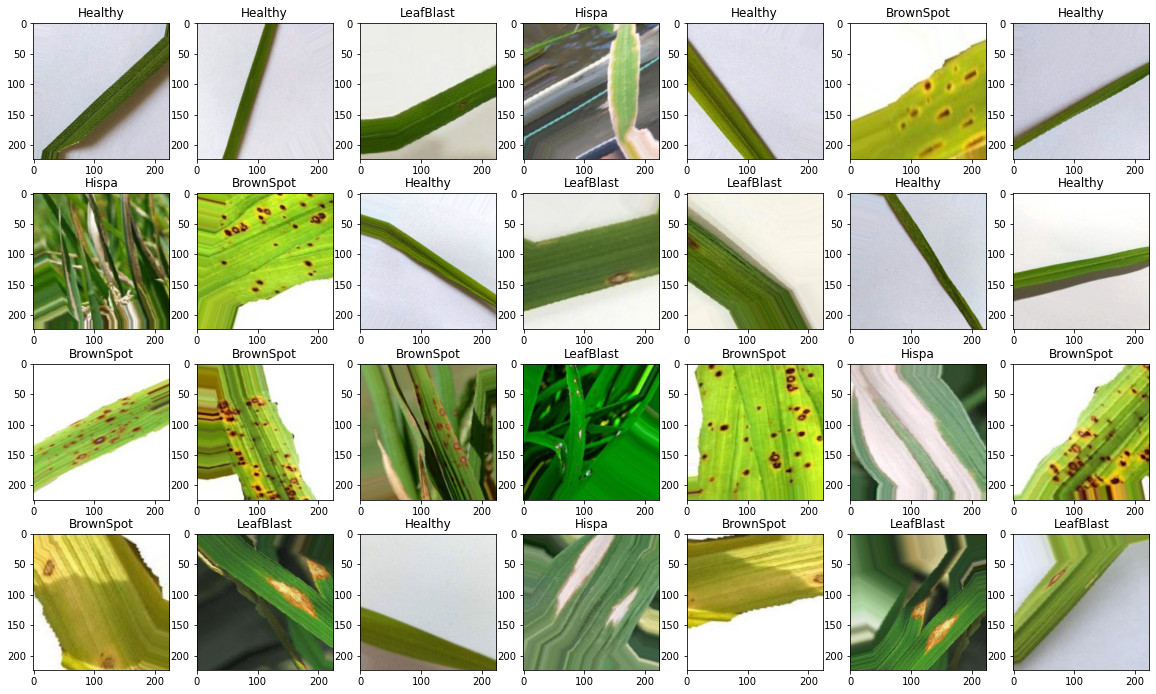

In [6]:
# preview images from train generator
r = 4; c = 7
n=0
classtolabel = {'0':'BrownSpot','1':'Healthy','2':'Hispa','3':'LeafBlast'}
for x in train_data:
    fig, axes = plt.subplots(r,c,figsize=(20,12))
    for i in range(r):
        for j in range(c):
            axes[i,j].imshow(x[0][n])
            label = np.argmax(x[1],axis=1)[n].astype('str')
            axes[i,j].set_title(classtolabel[label])
            n+=1    
    break

In [7]:
train_brownspot_dir = r"C:\Users\NOELII\Desktop\hb\RiceDiseaseDataset\train\BrownSpot"
train_healthy_dir = r"C:\Users\NOELII\Desktop\hb\RiceDiseaseDataset\train\Healthy"
train_hispa_dir = r"C:\Users\NOELII\Desktop\hb\RiceDiseaseDataset\train\Hispa"
train_leafblast_dir = r"C:\Users\NOELII\Desktop\hb\RiceDiseaseDataset\train\LeafBlast"
print("total number of brownspot image for training: ", len(os.listdir(train_brownspot_dir)))
print("total number of health image for training: ", len(os.listdir(train_healthy_dir)))
print("total number of hispa image for training: ", len(os.listdir(train_hispa_dir)))
print("total number of leafblast image for training: ", len(os.listdir(train_leafblast_dir)))

total number of brownspot image for training:  477
total number of health image for training:  381
total number of hispa image for training:  494
total number of leafblast image for training:  544


In [8]:
val_brownspot_dir = r"C:\Users\NOELII\Desktop\hb\RiceDiseaseDataset\validation\BrownSpot"
val_healthy_dir = r"C:\Users\NOELII\Desktop\hb\RiceDiseaseDataset\validation\Healthy"
val_hispa_dir = r"C:\Users\NOELII\Desktop\hb\RiceDiseaseDataset\validation\Hispa"
val_leafblast_dir = r"C:\Users\NOELII\Desktop\hb\RiceDiseaseDataset\validation\LeafBlast"
print("total number of brownspot image for validation: ", len(os.listdir(val_brownspot_dir)))
print("total number of health image for validation: ", len(os.listdir(val_healthy_dir)))
print("total number of hispa image for validation: ", len(os.listdir(val_hispa_dir)))
print("total number of leafblast image for validation: ", len(os.listdir(val_leafblast_dir)))

total number of brownspot image for validation:  68
total number of health image for validation:  76
total number of hispa image for validation:  66
total number of leafblast image for validation:  67


In [9]:
image_names_training = os.listdir(train_leafblast_dir)
image_names_training[:10]
image_names_val =os.listdir(val_hispa_dir)
image_names_val[:10]

['blight_17_output.jpg',
 'blight_22_output.jpg',
 'blight__0_1040.jpg',
 'blight__0_1059.jpg',
 'blight__0_1071.jpg',
 'blight__0_1105.jpg',
 'blight__0_1222.jpg',
 'blight__0_1274.jpg',
 'blight__0_128 - Copy.jpg',
 'blight__0_1435.jpg']

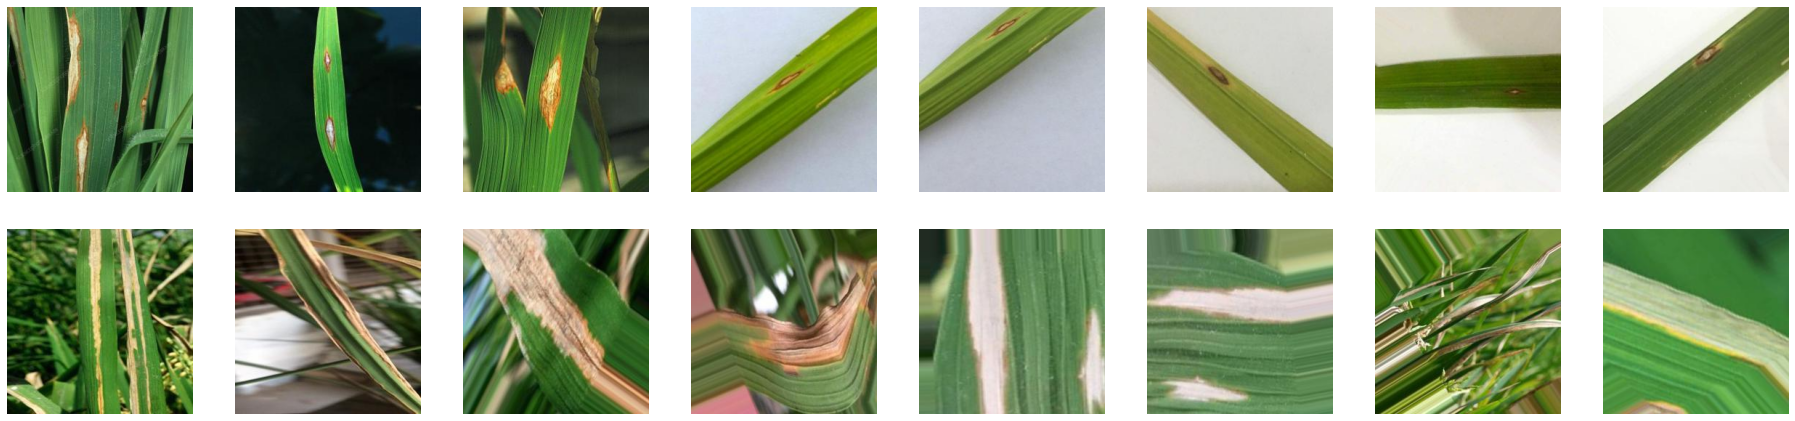

In [10]:
rows = 8
columns = 8
index = 0

#setting up matlibplot figure 
figure = plt.gcf()
figure.set_size_inches(columns*4, rows*4)

index+=8

image_training = [os.path.join(train_leafblast_dir, name) for name in image_names_training[index-8:index]]
image_val = [os.path.join(val_hispa_dir, name) for name in image_names_val[index-8:index]]

for i, img_path in enumerate(image_training + image_val):
    plot_img = plt.subplot(rows, columns, i + 1)
    plot_img.axis('off')
    
    img = mping.imread(img_path)
    plt.imshow(img)

plt.show()

In [174]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu',padding = 'Same', input_shape=(150,150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding = 'Same',),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding = 'Same'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu',padding = 'Same'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu',padding = 'Same'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu',padding = 'Same'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(rate=0.3),
    #flatten the outputs before feeding into deep neural network.
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(4, activation='softmax')
    ]);


#callbacks
filepath = r"C:\Users\NOELII\Desktop\hb\RiceDiseaseDataset\saved.model"

checkpointer = ModelCheckpoint(filepath, verbose=1, save_best_only=True, save_weights_only=True)
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=20, mode='auto')
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, mode='auto')

In [175]:
 model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_104 (Conv2D)          (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_104 (MaxPoolin (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_105 (Conv2D)          (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_105 (MaxPoolin (None, 37, 37, 64)        0         
_________________________________________________________________
dropout_52 (Dropout)         (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_106 (Conv2D)          (None, 37, 37, 64)        36928     
_________________________________________________________________
max_pooling2d_106 (MaxPoolin (None, 18, 18, 64)      

In [176]:
#Implement the callback function so that whenever the validation data reaches 98% accuracy the training will be terminated 
#implement the saving model after each epoch so that wiil load the model without re-training it.

In [177]:
# #implementing the callback funtion
# validation_accuracy=0.98
# class trainCallback(tf.keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs={}):
#         if(logs.get('val_accuracy') >= validation_accuracy):
#             print("\nreaching the the accuracy value which needed,")
#             print("\training is cancelled")
#             self.model.stop_training=True 
            
# callbacks = trainCallback()

In [178]:
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])

In [32]:
model.save("mymodel.h5")

In [67]:
new_model = tf.keras.models.load_model(
    'mymodel.h5',
    custom_objects=None,
    compile=True
)


In [68]:
new_model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_104 (Conv2D)          (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_104 (MaxPoolin (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_105 (Conv2D)          (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_105 (MaxPoolin (None, 37, 37, 64)        0         
_________________________________________________________________
dropout_52 (Dropout)         (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_106 (Conv2D)          (None, 37, 37, 64)        36928     
_________________________________________________________________
max_pooling2d_106 (MaxPoolin (None, 18, 18, 64)      

In [185]:
loss, acc = new_model.evaluate(test_data, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100*acc))


  ...
    to  
  ['...']
2/2 - 6s - loss: 1.4067 - accuracy: 0.4000
Restored model, accuracy: 40.00%


In [204]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu',padding = 'Same', input_shape=(150,150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu',padding = 'Same',),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding = 'Same'),
     tf.keras.layers.MaxPooling2D(2, 2),
    #flatten the outputs before feeding into deep neural network.
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(4, activation='softmax')
    ]);

#callbacks
filepath2 = r"C:\Users\NOELII\Desktop\hb\RiceDiseaseDataset\saved.model2"

checkpointer2 = ModelCheckpoint(filepath, verbose=1, save_best_only=True, save_weights_only=True)
earlystopping2 = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=20, mode='auto')
reduceLR2 = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, mode='auto')


In [205]:
model2.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_116 (Conv2D)          (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_116 (MaxPoolin (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_117 (Conv2D)          (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pooling2d_117 (MaxPoolin (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_118 (Conv2D)          (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_118 (MaxPoolin (None, 18, 18, 64)        0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 20736)           

In [209]:
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [210]:
trained_model = model2.fit_generator(train_data,
                                     epochs=50,
                                     verbose=1,
                                     validation_data=val_data,
                                     callbacks=[checkpointer2, earlystopping2, reduceLR2],
                                     shuffle=True)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 49 steps, validate for 16 steps
Epoch 1/50


C:\Users\NOELII\Anaconda3\envs\tensorflow_gpu\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\NOELII\Anaconda3\envs\tensorflow_gpu\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


48/49 [============================>.] - ETA: 4s - loss: 1.4276 - accuracy: 0.2637
Epoch 00001: val_loss improved from inf to 1.40468, saving model to C:\Users\NOELII\Desktop\hb\RiceDiseaseDataset\saved.model
49/49 [==============================] - 254s 5s/step - loss: 1.4273 - accuracy: 0.2615 - val_loss: 1.4047 - val_accuracy: 0.2663
Epoch 2/50
48/49 [============================>.] - ETA: 3s - loss: 1.4037 - accuracy: 0.2723
Epoch 00002: val_loss improved from 1.40468 to 1.38948, saving model to C:\Users\NOELII\Desktop\hb\RiceDiseaseDataset\saved.model
49/49 [==============================] - 214s 4s/step - loss: 1.4046 - accuracy: 0.2692 - val_loss: 1.3895 - val_accuracy: 0.2581
Epoch 3/50
48/49 [============================>.] - ETA: 3s - loss: 1.3360 - accuracy: 0.3455
Epoch 00003: val_loss improved from 1.38948 to 1.26729, saving model to C:\Users\NOELII\Desktop\hb\RiceDiseaseDataset\saved.model
49/49 [==============================] - 219s 4s/step - loss: 1.3365 - accuracy: 0.

In [211]:
model2.save("mymodel2.h5")

In [69]:
new_model2 = tf.keras.models.load_model(
    'mymodel2.h5',
    custom_objects=None,
    compile=True
)

new_model2.summary()


Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_116 (Conv2D)          (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_116 (MaxPoolin (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_117 (Conv2D)          (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pooling2d_117 (MaxPoolin (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_118 (Conv2D)          (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_118 (MaxPoolin (None, 18, 18, 64)        0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 20736)           

In [232]:
loss, acc = new_model2.evaluate(test_data, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100*acc))


  ...
    to  
  ['...']
2/2 - 3s - loss: 1.5373 - accuracy: 0.4250
Restored model, accuracy: 42.50%


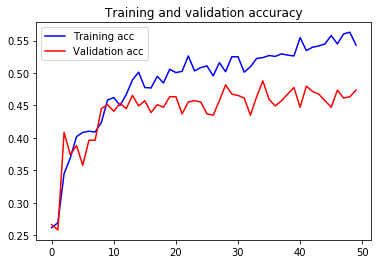

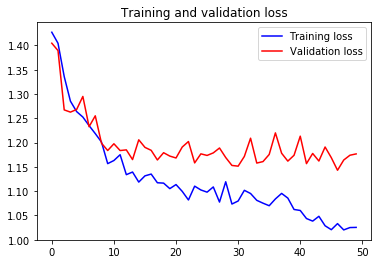

In [223]:
acc = trained_model.history['accuracy']
val_acc = trained_model.history['val_accuracy']
loss = trained_model.history['loss']
val_loss = trained_model.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [71]:

)

SyntaxError: invalid syntax (<ipython-input-71-a35077a93b18>, line 1)

In [17]:
model3 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(128, (3,3), activation='relu',padding = 'Same', input_shape=(224,224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu',padding = 'Same',),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding = 'Same',),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding = 'Same',),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu',padding = 'Same',),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu',padding = 'Same',),
    tf.keras.layers.MaxPooling2D(2, 2),
    #flatten the outputs before feeding into deep neural network.
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
     tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
    ]);

#callbacks
filepath3 = r"C:\Users\NOELII\Desktop\hb\RiceDiseaseDataset\saved.model3"

checkpointer3 = ModelCheckpoint(filepath3, verbose=1, save_best_only=True, save_weights_only=True)
earlystopping3 = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=20, mode='auto')
reduceLR3 = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, mode='auto')

model3.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 128)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        3

In [18]:
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [19]:
trained_model3 = model3.fit_generator(train_data,
                                     epochs=100,
                                     steps_per_epoch=49, 
                                     verbose=1,
                                     validation_data=val_data,
                                     callbacks=[checkpointer3, earlystopping3, reduceLR3],
                                     shuffle=True)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 49 steps, validate for 50 steps
Epoch 1/100
48/49 [============================>.] - ETA: 13s - loss: 1.3887 - accuracy: 0.2515
Epoch 00001: val_loss improved from inf to 1.38634, saving model to C:\Users\NOELII\Desktop\hb\RiceDiseaseDataset\saved.model3
49/49 [==============================] - 763s 16s/step - loss: 1.3887 - accuracy: 0.2534 - val_loss: 1.3863 - val_accuracy: 0.2500
Epoch 2/100
48/49 [============================>.] - ETA: 14s - loss: 1.3682 - accuracy: 0.2796
Epoch 00002: val_loss improved from 1.38634 to 1.36412, saving model to C:\Users\NOELII\Desktop\hb\RiceDiseaseDataset\saved.model3
49/49 [==============================] - 772s 16s/step - loss: 1.3661 - accuracy: 0.2816 - val_loss: 1.3641 - val_accuracy: 0.3089
Epoch 3/100
48/49 [============================>.] - ETA: 13s - loss: 1.2830 - accuracy: 0.3667
Epoch 00003: val_loss im

In [21]:
model3.save("mymodel3.h5")

In [7]:
new_model3 = tf.keras.models.load_model(
    'mymodel3.h5',
    custom_objects=None,
    compile=True
)

new_model3.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 128)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        3

In [8]:
loss, acc = new_model3.evaluate(test_data, verbose=1)
print('Restored model, accuracy: {:5.2f}%'.format(100*acc))

  ...
    to  
  ['...']
4/4 [==============================] - 7s 2s/step - loss: 1.0346 - accuracy: 0.6000
Restored model, accuracy: 60.00%


In [9]:
acc = trained_model3.history['accuracy']
val_acc = trained_model3.history['val_accuracy']
loss = trained_model3.history['loss']
val_loss = trained_model3.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

NameError: name 'trained_model3' is not defined

In [19]:
print(tf.__version__)

2.1.0


In [23]:
brownspot_test = r"G:\rice\20200504_173913.jpg"

img = image.load_img(brownspot_test, target_size=(224, 224))
array = image.img_to_array(img)
x = np.expand_dims(array, axis=0)
vimage = np.vstack([x])


In [24]:
new_model3.predict(vimage)

array([[0., 0., 0., 1.]], dtype=float32)

In [59]:
new_model3 = tf.keras.models.load_model(
    'mymodel3.h5',
    custom_objects=None,
    compile=True
)

new_model3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 128)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        3

In [60]:
test_gen = ImageDataGenerator(rescale= 1./255)

In [61]:
test_dir =  r"C:\Users\NOELII\Desktop\hb\RiceDiseaseDataset\test"
test_data =test_gen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    classes=['BrownSpot', 'Healthy', 'Hispa', 'LeafBlast'],
    class_mode='categorical')

Found 77 images belonging to 4 classes.


In [63]:
predictions = new_model3.predict_generator(
    test_data, 
    steps=None, 
    callbacks=None, 
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False, 
    verbose=0
)

In [64]:
print(predictions)

[[4.19597775e-02 1.00078911e-01 5.62095702e-01 2.95865595e-01]
 [2.92234700e-02 1.54752135e-01 6.61605656e-01 1.54418737e-01]
 [2.09835514e-01 7.53229678e-01 3.66591732e-03 3.32689174e-02]
 [1.17030470e-02 7.46380270e-01 2.19280943e-01 2.26357616e-02]
 [8.61014414e-04 4.28208295e-04 5.05742764e-06 9.98705745e-01]
 [1.29565634e-02 6.97620988e-01 2.67942965e-01 2.14794483e-02]
 [1.31689944e-06 4.18881740e-04 5.79870196e-08 9.99579728e-01]
 [4.87488796e-05 2.85588775e-10 1.10019930e-13 9.99951243e-01]
 [8.68331552e-01 3.83576402e-03 2.50372128e-03 1.25328973e-01]
 [1.83715850e-01 2.12865160e-03 2.61952737e-05 8.14129353e-01]
 [1.54687456e-04 2.32249920e-04 1.35716827e-09 9.99613106e-01]
 [9.96626019e-01 5.98489831e-04 2.49480545e-05 2.75059696e-03]
 [2.98111551e-02 6.38482034e-01 2.99999505e-01 3.17073166e-02]
 [4.18360569e-02 8.30951691e-01 1.09023102e-01 1.81891117e-02]
 [9.07171667e-01 2.98661849e-04 2.96581071e-04 9.22330990e-02]
 [9.95211303e-01 9.21239121e-07 1.80575967e-07 4.787592

In [65]:
#Confution Matrix and Classification Report
Y_pred = new_model3.predict_generator(test_data_generator, steps=test_steps_per_epoch)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_data_generator.classes, y_pred))
print('Classification Report')
target_names = ['BrownSpot', 'Healthy', 'Hispa', 'LeafBlast']
print(classification_report(test_data_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[ 4  0  0 11]
 [ 0  0  0 16]
 [ 0  0  0 24]
 [ 1  0  0 21]]
Classification Report
              precision    recall  f1-score   support

   BrownSpot       0.80      0.27      0.40        15
     Healthy       0.00      0.00      0.00        16
       Hispa       0.00      0.00      0.00        24
   LeafBlast       0.29      0.95      0.45        22

    accuracy                           0.32        77
   macro avg       0.27      0.31      0.21        77
weighted avg       0.24      0.32      0.21        77



C:\Users\NOELII\Anaconda3\envs\tensorflow_gpuenv\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
model6 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(128, (3,3), activation='relu',padding = 'Same', input_shape=(224,224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu',padding = 'Same',),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding = 'Same',),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding = 'Same',),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu',padding = 'Same',),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu',padding = 'Same',),
    tf.keras.layers.MaxPooling2D(2, 2),
    #flatten the outputs before feeding into deep neural network.
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
     tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
    ]);

#callbacks
filepath6 = r"C:\Users\NOELII\Desktop\hb\RiceDiseaseDataset\saved.model6"

checkpointer6 = ModelCheckpoint(filepath6, verbose=1, save_best_only=True, save_weights_only=True)
earlystopping6 = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=20, mode='auto')
reduceLR6 = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, mode='auto')

model6.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 128)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        3

In [13]:
model6.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [14]:
trained_model6 = model6.fit_generator(train_data,
                                     epochs=50,
                                     steps_per_epoch=49, 
                                     verbose=1,
                                     validation_data=val_data,
                                     callbacks=[checkpointer6, earlystopping6, reduceLR6],
                                     shuffle=True)

model6.save("mymodel6.h5")

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 49 steps, validate for 28 steps
Epoch 1/50
48/49 [============================>.] - ETA: 13s - loss: 1.1127 - accuracy: 0.4362
Epoch 00001: val_loss improved from inf to 0.68554, saving model to C:\Users\NOELII\Desktop\hb\RiceDiseaseDataset\saved.model6
49/49 [==============================] - 694s 14s/step - loss: 1.1095 - accuracy: 0.4413 - val_loss: 0.6855 - val_accuracy: 0.7040
Epoch 2/50
48/49 [============================>.] - ETA: 12s - loss: 0.7297 - accuracy: 0.7134
Epoch 00002: val_loss improved from 0.68554 to 0.47458, saving model to C:\Users\NOELII\Desktop\hb\RiceDiseaseDataset\saved.model6
49/49 [==============================] - 669s 14s/step - loss: 0.7265 - accuracy: 0.7142 - val_loss: 0.4746 - val_accuracy: 0.8123
Epoch 3/50
48/49 [============================>.] - ETA: 12s - loss: 0.6925 - accuracy: 0.7134
Epoch 00003: val_loss did n

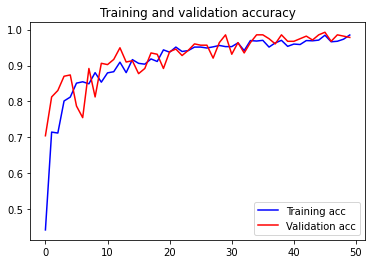

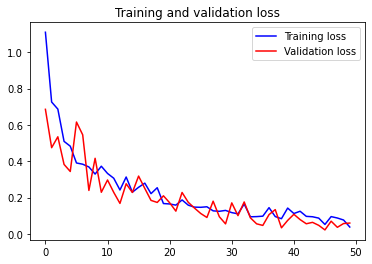

In [18]:
acc = trained_model6.history['accuracy']
val_acc = trained_model6.history['val_accuracy']
loss = trained_model6.history['loss']
val_loss = trained_model6.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [1]:
import tensorflow as tf
model = tf.keras.models.load_model('mymodel6.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("mymodel6.tflite", "wb").write(tflite_model)

1887560

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mping 
from keras.preprocessing import image as image_over
import numpy as np




In [16]:
brownspot_test = r"C:\Users\NOELII\Desktop\hb\RiceDiseaseDataset\test\LeafBlast\blast_07_output.jpg"

img = image_over.load_img(brownspot_test, target_size=(224, 224))
array = image_over.img_to_array(img)
x = np.expand_dims(array, axis=0)
vimage = np.vstack([x])

In [17]:
new_model3.predict(vimage)

array([[1., 0., 0., 0.]], dtype=float32)

In [18]:
!pip install pillow

In [7]:
new_model3 = tf.keras.models.load_model(
    'mymodel6.h5',
    custom_objects=None,
    compile=True
)

new_model3.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 128)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        3

In [3]:
new_model6 = tf.keras.models.load_model(
    'mymodel6.h5',
    custom_objects=None,
    compile=True
)

new_model6.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 128)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        3

In [4]:
test_gen = ImageDataGenerator(rescale= 1./255)

In [18]:
test_dir =  r"C:\Users\NOELII\Desktop\hb\RiceDiseaseDataset\test"
test_data =test_gen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    classes=['BrownSpot', 'Healthy', 'Hispa', 'LeafBlast'],
    class_mode='categorical')

Found 77 images belonging to 4 classes.


In [7]:
predictions = new_model6.predict_generator(
    test_data, 
    steps=None, 
    callbacks=None, 
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False, 
    verbose=0
)

Instructions for updating:
Please use Model.predict, which supports generators.


In [8]:
predictions

array([[2.3283592e-06, 3.9163883e-06, 1.1251755e-05, 9.9998248e-01],
       [8.0705842e-09, 9.9999642e-01, 1.6998434e-09, 3.5182150e-06],
       [1.9803558e-07, 9.9998295e-01, 5.7487624e-09, 1.6782893e-05],
       [7.2370056e-04, 1.1439538e-04, 2.1360937e-07, 9.9916172e-01],
       [1.0916093e-04, 2.6371055e-07, 9.9415392e-01, 5.7367142e-03],
       [4.3561492e-02, 6.0640592e-03, 1.5619962e-04, 9.5021820e-01],
       [2.1442825e-10, 9.9999845e-01, 6.2624944e-10, 1.5411262e-06],
       [5.9317077e-08, 9.9998939e-01, 7.5370066e-09, 1.0595026e-05],
       [9.9999976e-01, 2.1673080e-17, 1.2808104e-16, 2.7029913e-07],
       [3.9899253e-09, 9.9998796e-01, 5.5525184e-08, 1.2090573e-05],
       [8.6919940e-01, 7.3768409e-05, 2.5376485e-04, 1.3047302e-01],
       [9.9265963e-01, 2.3917721e-06, 1.3767845e-05, 7.3243566e-03],
       [5.4665020e-07, 9.9993014e-01, 2.0528267e-08, 6.9196780e-05],
       [5.6973126e-06, 9.9977666e-01, 5.9368290e-08, 2.1766934e-04],
       [1.1064032e-08, 3.4523936e-

In [73]:
y_pre = np.argmax(predictions, axis=1)

In [74]:
print(y_pre)

[2 2 1 1 3 1 3 3 0 3 3 0 1 1 0 0 3 3 0 1 3 3 3 0 1 1 3 2 3 2 2 0 3 3 3 3 3
 3 3 3 1 3 1 1 3 3 2 1 3 3 3 1 3 3 1 2 1 0 1 3 3 3 1 0 3 3 3 3 0 0 2 0 2 1
 3 1 1]


In [24]:
!pip install sklearn

  Using cached sklearn-0.0.tar.gz (1.1 kB)
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1320 sha256=0b3f29a25872de85af496a5eb2ebc26f7e14ef4b9d1bf7fee8840f2cf95f4a99
  Stored in directory: c:\users\noelii\appdata\local\pip\cache\wheels\46\ef\c3\157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built sklearn


In [48]:
%matplotlib inline 
from sklearn.metrics import confusion_matrix,classification_report
import itertools
import matplotlib.pyplot as plt
import numpy
import sklearn.metrics as metrics
from sklearn import preprocessing


In [33]:
test_dir =  r"C:\Users\NOELII\Desktop\hb\RiceDiseaseDataset\test"

test_generator = ImageDataGenerator()
test_data_generator = test_generator.flow_from_directory(
    test_dir, #Put your path here
     target_size=(224, 224),
    batch_size=32,
    shuffle=False,
    classes=['BrownSpot', 'Healthy', 'Hispa', 'LeafBlast'],
    class_mode='categorical'
)
test_steps_per_epoch = numpy.math.ceil(test_data_generator.samples / test_data_generator.batch_size)

predictions = new_model6.predict_generator(test_data_generator, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = numpy.argmax(predictions, axis=1)


Found 77 images belonging to 4 classes.


In [34]:
true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys())   

In [44]:
#Confution Matrix and Classification Report
Y_pred = new_model6.predict_generator(test_data_generator, steps=test_steps_per_epoch)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_data_generator.classes, y_pred))
print('Classification Report')
target_names = ['BrownSpot', 'Healthy', 'Hispa', 'LeafBlast']
print(classification_report(test_data_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[11  0  3  1]
 [ 2 13  0  1]
 [ 4  8 11  1]
 [11  5  1  5]]
Classification Report
              precision    recall  f1-score   support

   BrownSpot       0.39      0.73      0.51        15
     Healthy       0.50      0.81      0.62        16
       Hispa       0.73      0.46      0.56        24
   LeafBlast       0.62      0.23      0.33        22

    accuracy                           0.52        77
   macro avg       0.56      0.56      0.51        77
weighted avg       0.59      0.52      0.50        77

